# Hyperparameter Evaluation - __K Nearest Neighbor__ with the Paletes Dataset
We shall test both the _RGB_ and the _HLS_ colour schemes for the best results.

In [1]:
from PIL import Image
from sklearn.exceptions import DataConversionWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

## Helper Functions

The standard <code>read_data()</code> function seen throughout the project. designed to simplify and standardize the data reading process. <br/>In addition the _Global_ variables associated with its function are defined along with the relitive paths to the data files.<br/>__NOTE:__ in a business environment this function would be placed into a pythin module and imported. Here it is included into the notebook to provide full transparency. 

In [2]:
# required modules
import numpy as np
import pandas as pd
import sqlite3
from sklearn import preprocessing
import colorsys

# groups
COLOURS      = 10
PALETTES     = 11
LRG_PALETTES = 12
IMAGE        = 13
TILES        = 14

# sets
TRAIN        = 20
TEST         = 21
VALIDATE     = 22

# targets
ARTIST       = 30
GENRE        = 31
STYLE        = 32

# array
DATA         = 40
CATAGORY     = 41
CATAGORY_NUM = 42
IMAGE_TAG    = 43
TILE_INDEX   = 44

# colour systems
HLS          = 50
RGB          = 51
RAW          = 52

# an overly complicated method of defining the data file path
data_file  = {COLOURS      : {TRAIN    : {ARTIST : "./data/colour_sets/artist_train_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_train_colours.npz",
                                          STYLE  : "./data/colour_sets/style_train_colours.npz"},
                              TEST     : {ARTIST : "./data/colour_sets/artist_test_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_test_colours.npz",
                                          STYLE  : "./data/colour_sets/style_test_colours.npz"} ,
                              VALIDATE : {ARTIST : "./data/colour_sets/artist_validation_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_validation_colours.npz",
                                          STYLE  : "./data/colour_sets/style_validation_colours.npz"}},
              PALETTES     : {TRAIN    : {ARTIST : "./data/palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_validation_palettes.npz"}},
              LRG_PALETTES : {TRAIN    : {ARTIST : "./data/large_palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/large_palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/large_palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_validation_palettes.npz"}},
              IMAGE        : {TRAIN    : {ARTIST : "./data/full_image_feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/full_image_feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/full_image_feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_validation_features.npz"}},
              TILES        : {TRAIN    : {ARTIST : "./data/feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/feature_sets/style_validation_features.npz"}}}

# Create a DB connection between python and the file system
conn = sqlite3.connect("./data/database/artist.db")

# the fuction that provides a standard data read method
def read_data(data_group, data_set, data_target, data_type, colour_system = RGB):
    
    # read the data file
    data = np.load(data_file[data_group][data_set][data_target], allow_pickle=True)

    # if tile index is requested
    if   data_type    == TILE_INDEX:
        # when group is tiles, return the tile indexes
        if data_group == TILES:
            return pd.DataFrame(data["arr_3"], columns = {"tile_index"})
        # otherwise, just return an emtpy dataset
        else:
            return pd.DataFrame(columns = {"tile_index"})
    # if image tags are requested
    elif data_type == IMAGE_TAG:
        return pd.DataFrame(data["arr_2"], columns = {"image_tag"})
    # if catagory data is requested
    elif data_type == CATAGORY:
        return pd.DataFrame(data["arr_1"], columns = {"catagory"})
    # if catagory_num is requested
    elif data_type == CATAGORY_NUM:
        # select data for the appropriate lookup table
        if   data_target == ARTIST: 
            query_string = "SELECT ID, NAME  AS VALUE FROM ARTIST"
        elif data_target == GENRE:
            query_string = "SELECT ID, GENRE AS VALUE FROM GENRE"
        else:
            query_string = "SELECT ID, STYLE AS VALUE FROM STYLE" 
        # build the lookup table
        lookup = pd.read_sql_query(query_string, conn)
        # get the catagory data
        data   = pd.DataFrame(data["arr_1"], columns = {"catagory"})
        # convert the catagory text labels to numeric catagory ids
        return pd.DataFrame(data["catagory"].apply(lambda x: lookup[lookup["VALUE"] == x]["id"].values[0]))
    # data requested
    elif data_group == COLOURS:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[1] * data["arr_0"].shape[2])))
    elif data_group == PALETTES or data_group == LRG_PALETTES:

        # extract the colour data
        colour_data = data["arr_0"]
        
        # find the datas dimensions
        records, _, palette_length, palette_layers = np.shape(colour_data)
        
        # reshape
        colour_data = colour_data.reshape(records * palette_length, palette_layers)
        
        # convert to a dataframe
        colour_data_df = pd.DataFrame(colour_data, columns =["r","g","b"])
        
        # process the data with different colour systems
        
        # hue, luminance, saturation
        if colour_system == HLS:
            
            # define a dataframe to hold the hls values
            hls_data_df = pd.DataFrame(columns =["h","l","s"])

            # loop through each record
            for row in colour_data_df.iterrows():
                
                # extract the r,g,b values and devide them by 255 ready to convert
                r, g, b = row[1].values/255

                # convert the values and add them to the dataframe
                hls_data_df.loc[len(hls_data_df)] = colorsys.rgb_to_hls(r, g, b)
            
            # create datasets and normalize
            hue        = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["h"]).reshape(records, palette_length)))
            luminance  = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["l"]).reshape(records, palette_length)))
            saturation = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["s"]).reshape(records, palette_length)))  
            
            # return values
            return hue, luminance, saturation
            
        # red, green, blue unnormalized
        elif colour_system == RAW:
            red   = pd.DataFrame(np.array(colour_data_df["r"]).reshape(records, palette_length))
            green = pd.DataFrame(np.array(colour_data_df["g"]).reshape(records, palette_length))
            blue  = pd.DataFrame(np.array(colour_data_df["b"]).reshape(records, palette_length))
            
            # return values
            return red, green, blue            
            
        # red, green, blue normalized- (default)
        else:
    
            # create datasets and normalize
            red   = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["r"]).reshape(records, palette_length)))
            green = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["g"]).reshape(records, palette_length)))
            blue  = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["b"]).reshape(records, palette_length)))
            
            # return values
            return red, green, blue

    elif data_group == IMAGE:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[2])))
    else:
        # normalize the data
        return pd.DataFrame(preprocessing.normalize(data["arr_0"]))  

The function <code>get_optimum_neighbors_and_accuracy()</code> training and testing data sets and the maximum number of neighbors and then loops through the neighbor count upto the maximum value. During each loop the test set is used to evaluate the accurancy. The number of neighbors with the highest accuracy is finally returned along with the tests accuracy value. It the <code>show_plot</code> is set to <code>True</code>. A plot of the accuracy values for each of the neighbor count values will be plotted. The optimum neighbor count is highlighted with the use of a red point.

In [3]:
def get_optimum_neighbors_and_accuracy(X_train, y_train, X_test, y_test, max_neighbors, show_plot = False):

    accuracy_uniform                 = []
    neighbors_uniform                = []
    accuracy_distance                = []
    neighbors_distance               = []
    optimum_no_of_neighbors          = 0
    highest_accuracy                 = 0
    optimum_no_of_neighbors_uniform  = 0
    highest_accuracy_uniform         = 0
    optimum_no_of_neighbors_distance = 0
    highest_accuracy_distance        = 0
    optimum_weights                  = ""

    # internal helper function to calculate accuracy for a given neighbor count
    def get_accuracy(no_of_neighbors, weights):
    
        # create a k-NN pipeline
        knn_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("knn"   , KNeighborsClassifier(n_neighbors = no_of_neighbors,
                                            weights     = weights, 
                                            n_jobs      = -1))
        ])

        # fit estimator
        knn_pipe.fit(X_train, y_train)

        # evaluate on test set
        return knn_pipe.score(X_test, y_test)

    # instead of using gridsearch, here we use our own method to loop through 
    # neighbor count 
    for number_of_neighbors in range(1, max_neighbors):
        
        # add new neighbor count to the list
        neighbors_uniform.append(number_of_neighbors)
        neighbors_distance.append(number_of_neighbors)
        
        # calculate the accurancy for the neighbor count
        calculated_accuracy_uniform  = get_accuracy(number_of_neighbors, "uniform")
        calculated_accuracy_distance = get_accuracy(number_of_neighbors, "distance")

        # add new accuracy to the list
        accuracy_uniform.append(calculated_accuracy_uniform)
        accuracy_distance.append(calculated_accuracy_distance)

        # compare and save the best scores
        if calculated_accuracy_uniform      >= highest_accuracy_uniform:
            highest_accuracy_uniform         = calculated_accuracy_uniform
            optimum_no_of_neighbors_uniform  = number_of_neighbors
            
        if calculated_accuracy_distance     >= highest_accuracy_distance:
            highest_accuracy_distance        = calculated_accuracy_distance
            optimum_no_of_neighbors_distance = number_of_neighbors
                
    if highest_accuracy_uniform > highest_accuracy_distance:
        optimum_no_of_neighbors = optimum_no_of_neighbors_uniform
        highest_accuracy        = highest_accuracy_uniform
        optimum_weights         = "uniform"
    else:
        optimum_no_of_neighbors = optimum_no_of_neighbors_distance
        highest_accuracy        = highest_accuracy_distance
        optimum_weights         = "distance"
                
    if show_plot:
        # display out results    
        plt.rcParams["figure.figsize"] = [25, 7]
        # plot neighbors to accuracy
        plt.plot(neighbors_uniform,                accuracy_uniform,          color = "cornflowerblue", marker = "o", label = "Uniform")  
        plt.plot(neighbors_distance,               accuracy_distance,         color = "salmon",         marker = "o", label = "Distance")
        # plot optimum number of neighbors
        plt.plot(optimum_no_of_neighbors,          highest_accuracy        ,  color = "lightgrey",      marker = "o", ms = 25)
        plt.plot(optimum_no_of_neighbors_uniform,  highest_accuracy_uniform,  color = "darkblue",       marker = "o", ms = 10)
        plt.plot(optimum_no_of_neighbors_distance, highest_accuracy_distance, color = "red",            marker = "o", ms = 10)
        plt.title("Accuracy by Tuning Number of Neighbors.")
        plt.xlabel("Number of Neighbors")
        plt.ylabel("Accuracy")
        plt.grid(True, c = "whitesmoke")
        plt.legend()
        plt.show()
        
    # return the optimum neighbor count that gives the highest accuracy
    return optimum_no_of_neighbors, optimum_weights, highest_accuracy

Display the artwork image associated with the given <code>image_tag</code> and label it with:
- the Title
- the Artist
- the Genre
- the Style
the image is loaded from file, whereas the details are extracted from the RDBMS.

In [4]:
# display an image file
def show_artwork(artwork_id, data_set = TEST):

    data_file_path  = "./data/"
    image_file_path = "".join([data_file_path, "images/"]) 
    image_tag       = read_data(IMAGE, data_set, ARTIST, IMAGE_TAG)["image_tag"][artwork_id]
    image_path      = "".join([image_file_path, "full_image_", image_tag ,".jpg"])

    # Load the image
    artwork_image = Image.open(image_path).convert('RGB')

    # convert it into a numpy array
    img_array  = np.array(artwork_image)

    # define query to retrieve artwork information from the database
    query_string = """
SELECT TITLE,
       NAME,
       GENRE,
       STYLE
FROM ARTWORK_IMAGE AS A,
     ARTWORK       AS B,
     ARTIST        AS C,
     GENRE         AS D,
     ARTWORK_STYLE AS E,
     STYLE         AS F
WHERE A.IMAGE_TAG = "{}"
AND   A.ARTWORK_ID = B.ID
AND   B.ARTIST_ID  = C.ID
AND   B.GENRE_ID   = D.ID
AND   B.ID         = E.ARTWORK_ID
AND   E.STYLE_ID   = F.ID
""".format(image_tag)

    # connect to the database
    conn = sqlite3.connect("./data/database/artist.db")
    
    # execute query
    lookup = pd.read_sql_query(query_string, conn)
    
    # extract the values from the returned dataset
    style = ""
    for rec in lookup.iterrows():
        title  = rec[1][0]
        artist = rec[1][1]
        genre  = rec [1][2]
        style  = ", ".join([rec[1][3], style  ]).strip(", ")

    # create a figure to grid plot into
    fig = plt.figure(figsize=(10, 8))

    # Plot the image
    plt.imshow(img_array)
    plt.xlabel("TITLE: {}\nARTIST: {}\nGENRE: {}\nSTYLE(S): {}".format(title, artist, genre, style), position=(0., 1e6), horizontalalignment='left')
    plt.xticks([])
    plt.yticks([])
    
    # show our handy work
    plt.show()    

The function <code>predict_artwork_artist()</code> takes a provided <code>artwork_id</code> and then tries to identify the Artist. There are three addition parameters that can be set: <br/>
- <code>neighbors</code> the number of neighbors to use. Default: __4__ (_the value with the highest test score_).
- <code>group</code> here we are interested in using the __IMAGE__ data. So, Default is set to: __IMAGE__. But the other data groups could be used with this function.
- <code>data_set</code> Default: __TEST__.

In [5]:
def predict_artwork_artist(artwork_id, neighbors = 4, colour_scheme = RGB):
    
    # create a k-NN pipeline
    knn_pipe = Pipeline([("scaler", StandardScaler()),
                         ("knn"   , KNeighborsClassifier(n_neighbors = neighbors))
                        ])

    
    l, r, f = np.shape(read_data(PALETTES, TRAIN,  ARTIST, DATA, colour_scheme))
 
    # fit estimator
    knn_pipe.fit(np.reshape(read_data(PALETTES, TRAIN,  ARTIST, DATA, colour_scheme), (r, l * f)), 
                 read_data(PALETTES, TRAIN, ARTIST, CATAGORY))

    l, r, f = np.shape(read_data(PALETTES, TEST,  ARTIST, DATA, colour_scheme))
 
    # return prediction
    return knn_pipe.predict([pd.DataFrame(np.reshape(read_data(PALETTES, TEST, ARTIST, DATA), (r, l * f))).iloc[artwork_id]])[0]

The function <code>predict_artwork_style()</code> takes a provided <code>artwork_id</code> and then tries to identify the Style. There are three addition parameters that can be set: <br/>
- <code>neighbors</code> the number of neighbors to use. Default: __22__ (_the value with the highest test score_).
- <code>group</code> here we are interested in using the __IMAGE__ data. So, Default is set to: __IMAGE__. But the other data groups could be used with this function.
- <code>data_set</code> Default: __TEST__.

In [6]:
def predict_artwork_style(artwork_id, neighbors = 22, colour_scheme = RGB):
    
    # create a k-NN pipeline
    knn_pipe = Pipeline([("scaler", StandardScaler()),
                         ("knn"   , KNeighborsClassifier(n_neighbors = neighbors))
                        ])

    
    l, r, f = np.shape(read_data(PALETTES, TRAIN,  STYLE, DATA, colour_scheme))
 
    # fit estimator
    knn_pipe.fit(np.reshape(read_data(PALETTES, TRAIN, STYLE, DATA), (r, l * f)),  
                 read_data(PALETTES, TRAIN, STYLE, CATAGORY))

    l, r, f = np.shape(read_data(PALETTES, TEST,  STYLE, DATA, colour_scheme))
    
    # return prediction
    return knn_pipe.predict([pd.DataFrame(np.reshape(read_data(PALETTES, TEST, STYLE, DATA), (r, l * f))).iloc[artwork_id]])[0]

The function <code>predict_artwork_genre()</code> takes a provided <code>artwork_id</code> and then tries to identify the Genre. There are three addition parameters that can be set: <br/>
- <code>neighbors</code> the number of neighbors to use. Default: __10__ (_the value with the highest test score_).
- <code>group</code> here we are interested in using the __IMAGE__ data. So, Default is set to: __IMAGE__. But the other data groups could be used with this function.
- <code>data_set</code> Default: __TEST__.

In [7]:
def predict_artwork_genre(artwork_id, neighbors = 10, colour_scheme = RGB):
    
    # create a k-NN pipeline
    knn_pipe = Pipeline([("scaler", StandardScaler()),
                         ("knn"   , KNeighborsClassifier(n_neighbors = neighbors))
                        ])

    
    l, r, f = np.shape(read_data(PALETTES, TRAIN,  GENRE, DATA, colour_scheme))
 
    # fit estimator
    knn_pipe.fit(np.reshape(read_data(PALETTES, TRAIN, GENRE, DATA), (r, l * f)),  
                 read_data(PALETTES, TRAIN, GENRE, CATAGORY))

    l, r, f = np.shape(read_data(PALETTES, TEST,  GENRE, DATA, colour_scheme))
 
    # return prediction
    return knn_pipe.predict([pd.DataFrame(np.reshape(read_data(PALETTES, TEST, GENRE, DATA), (r, l * f))).iloc[artwork_id]])[0]

In [8]:
# turn off scikit-learn Warnings
warnings.filterwarnings(action='ignore', category = DataConversionWarning)

## Identify the Optimum Number of Neighbors for the _Genre_, _Style_ & _Artist_ Datasets
As the best results are returned. they are added to the <code>results</code> DataFrame.

In [9]:
results = pd.DataFrame()

## Optimum Neighbors for the _Genre_ Dataset.
__NOTE:__ in the plots we see results for both _Uniform_ & _Distance_ weights. The highest scoring number of neighbors is indicated with a larger dot. The best scoring oc the two best scores is surrounded with a larger Grey circle.

In [10]:
# create a training features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TRAIN, GENRE, DATA, RGB))
X_train_genre = np.reshape(read_data(PALETTES, TRAIN, GENRE, DATA, RGB), (r, l * f))

# create a test features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TEST,  GENRE, DATA, RGB))
X_test_genre  = np.reshape(read_data(PALETTES, TEST,  GENRE, DATA, RGB), (r, l * f))

# create a training target catagories dataFrame
y_train_genre = read_data(PALETTES, TRAIN, GENRE, CATAGORY, RGB)

# create a test target catagories  dataFrame
y_test_genre  = read_data(PALETTES, TEST,  GENRE, CATAGORY, RGB)

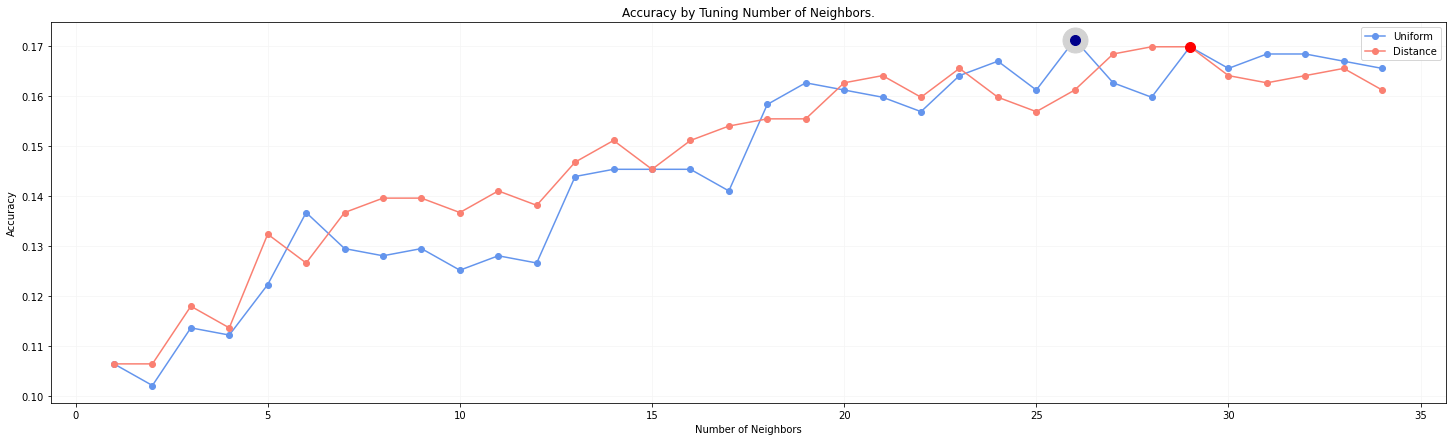

Accuracy: 0.171223 using: uniform with 26 neighbors


In [11]:
neighbors, weights, acc = get_optimum_neighbors_and_accuracy(X_train_genre, y_train_genre, X_test_genre, y_test_genre, 35, True)
          
# results
results = results.append({"classifier" : "K-NN",
                          "group"      : "PALETTES-RGB",
                          "target"     : "GENRE",
                          "score"      : round(acc, 6),
                          "params"     : {"neighbors" : neighbors, "weights" : weights}},
                          ignore_index = True)

print("Accuracy: {} using: {} with {} neighbors".format(round(acc, 6), weights, neighbors))

In [12]:
# create a training features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TRAIN, GENRE, DATA, HLS))
X_train_genre = np.reshape(read_data(PALETTES, TRAIN, GENRE, DATA, HLS), (r, l * f))

# create a test features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TEST,  GENRE, DATA, HLS))
X_test_genre  = np.reshape(read_data(PALETTES, TEST,  GENRE, DATA, HLS), (r, l * f))

# create a training target catagories dataFrame
y_train_genre = read_data(PALETTES, TRAIN, GENRE, CATAGORY, HLS)

# create a test target catagories  dataFrame
y_test_genre  = read_data(PALETTES, TEST,  GENRE, CATAGORY, HLS)

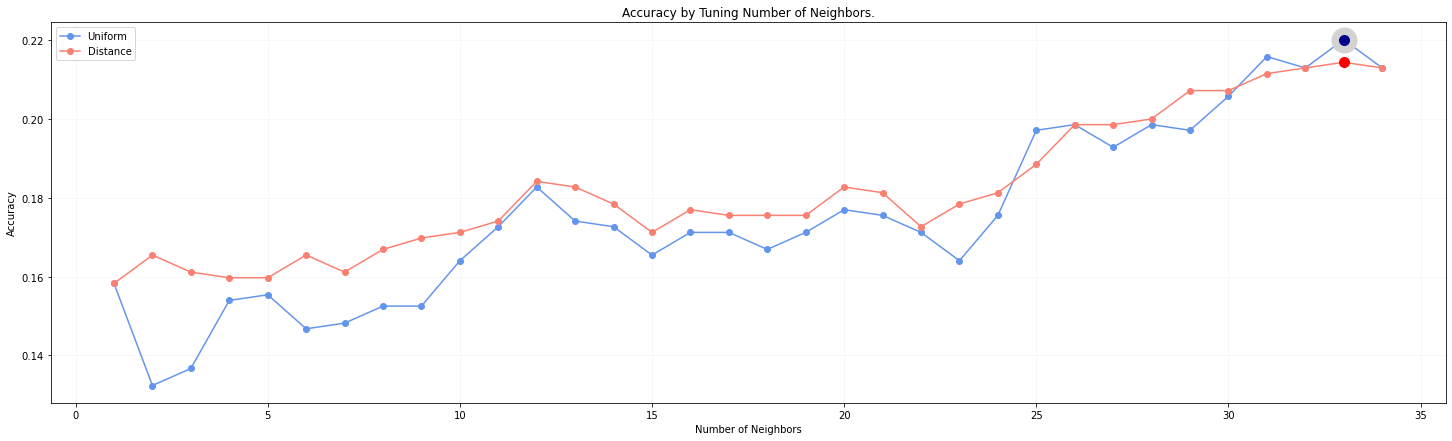

Accuracy: 0.220144 using: uniform with 33 neighbors


In [13]:
neighbors, weights, acc = get_optimum_neighbors_and_accuracy(X_train_genre, y_train_genre, X_test_genre, y_test_genre, 35, True)
          
# results
results = results.append({"classifier" : "K-NN",
                          "group"      : "PALETTES-HLS",
                          "target"     : "GENRE",
                          "score"      : round(acc, 6),
                          "params"     : {"neighbors" : neighbors, "weights" : weights}},
                          ignore_index = True)

print("Accuracy: {} using: {} with {} neighbors".format(round(acc, 6), weights, neighbors))

## Optimum Neighbors for the _Style_ Dataset.

In [14]:
# create a training features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TRAIN, STYLE, DATA, RGB))
X_train_style = np.reshape(read_data(PALETTES, TRAIN, STYLE, DATA, RGB), (r, l * f))

# create a test features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TEST,  STYLE, DATA, RGB))
X_test_style  = np.reshape(read_data(PALETTES, TEST,  STYLE, DATA, RGB), (r, l * f))

# create a training target catagories dataFrame
y_train_style = read_data(PALETTES, TRAIN, STYLE, CATAGORY, RGB)

# create a test target catagories  dataFrame
y_test_style  = read_data(PALETTES, TEST,  STYLE, CATAGORY, RGB)

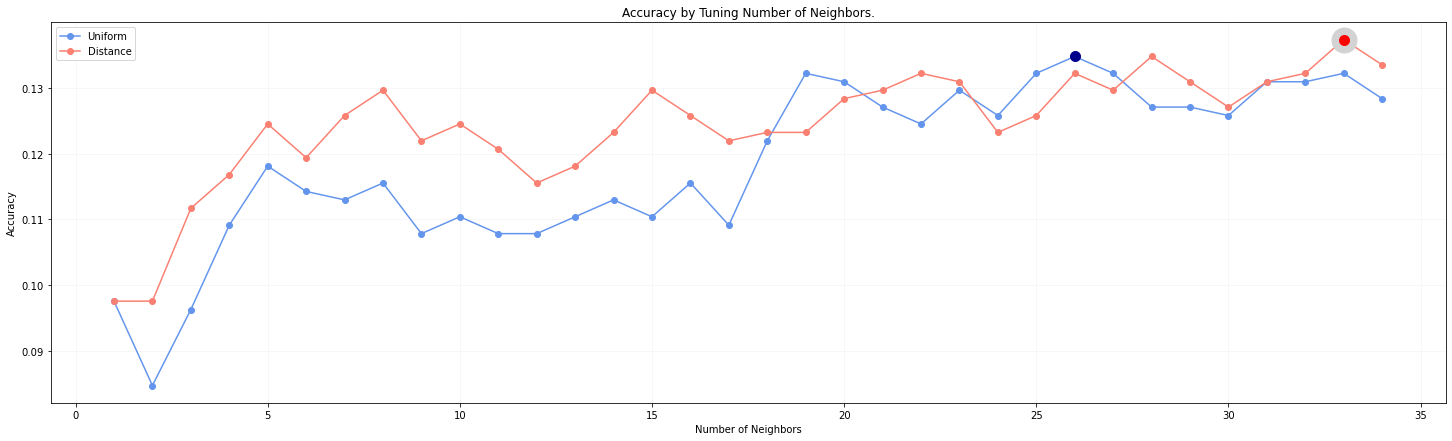

Accuracy: 0.137356 using: distance with 33 neighbors


In [15]:
neighbors, weights, acc = get_optimum_neighbors_and_accuracy(X_train_style, y_train_style, X_test_style, y_test_style, 35, True)
          
# results
results = results.append({"classifier" : "K-NN",
                          "group"      : "PALETTES-RGB",
                          "target"     : "STYLE",
                          "score"      : round(acc, 6),
                          "params"     : {"neighbors" : neighbors, "weights" : weights}},
                          ignore_index = True)

print("Accuracy: {} using: {} with {} neighbors".format(round(acc, 6), weights, neighbors))

In [16]:
# create a training features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TRAIN, STYLE, DATA, HLS))
X_train_style = np.reshape(read_data(PALETTES, TRAIN, STYLE, DATA, HLS), (r, l * f))

# create a test features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TEST,  STYLE, DATA, HLS))
X_test_style  = np.reshape(read_data(PALETTES, TEST,  STYLE, DATA, HLS), (r, l * f))

# create a training target catagories dataFrame
y_train_style = read_data(PALETTES, TRAIN, STYLE, CATAGORY, HLS)

# create a test target catagories  dataFrame
y_test_style  = read_data(PALETTES, TEST,  STYLE, CATAGORY, HLS)

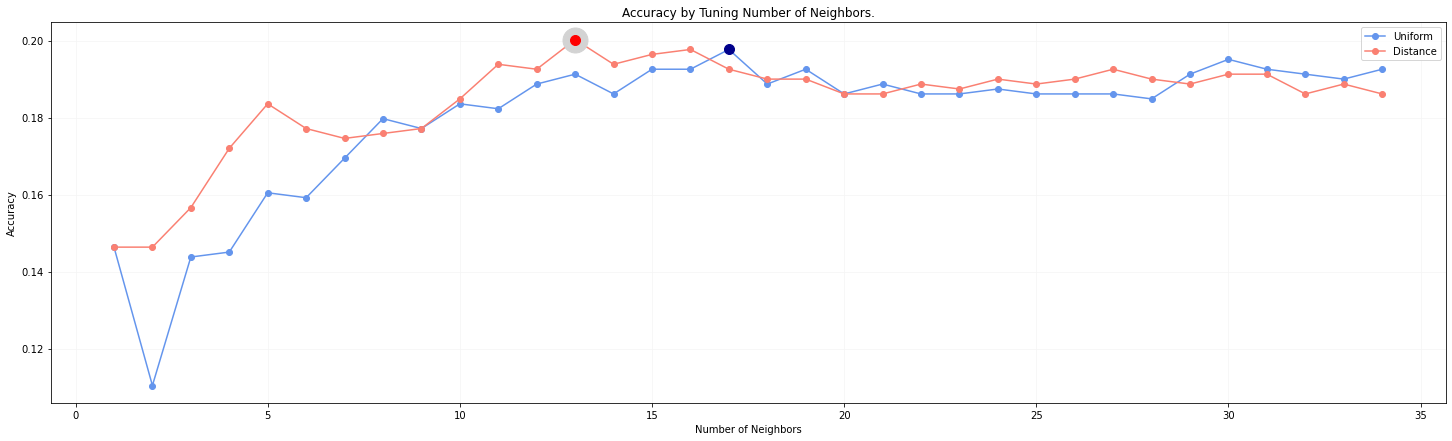

Accuracy: 0.200257 using: distance with 13 neighbors


In [17]:
neighbors, weights, acc = get_optimum_neighbors_and_accuracy(X_train_style, y_train_style, X_test_style, y_test_style, 35, True)
          
# results
results = results.append({"classifier" : "K-NN",
                          "group"      : "PALETTES-HLS",
                          "target"     : "STYLE",
                          "score"      : round(acc, 6),
                          "params"     : {"neighbors" : neighbors, "weights" : weights}},
                          ignore_index = True)

print("Accuracy: {} using: {} with {} neighbors".format(round(acc, 6), weights, neighbors))

## Optimum Neighbors for the _Artist_ Dataset.

In [18]:
# create a training features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TRAIN, ARTIST, DATA, RGB))
X_train_artist = np.reshape(read_data(PALETTES, TRAIN, ARTIST, DATA, RGB), (r, l * f))

# create a test features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TEST,  ARTIST, DATA, RGB))
X_test_artist  = np.reshape(read_data(PALETTES, TEST,  ARTIST, DATA, RGB), (r, l * f))

# create a training target catagories dataFrame
y_train_artist = read_data(PALETTES, TRAIN, ARTIST, CATAGORY, RGB)

# create a test target catagories  dataFrame
y_test_artist  = read_data(PALETTES, TEST,  ARTIST, CATAGORY, RGB)

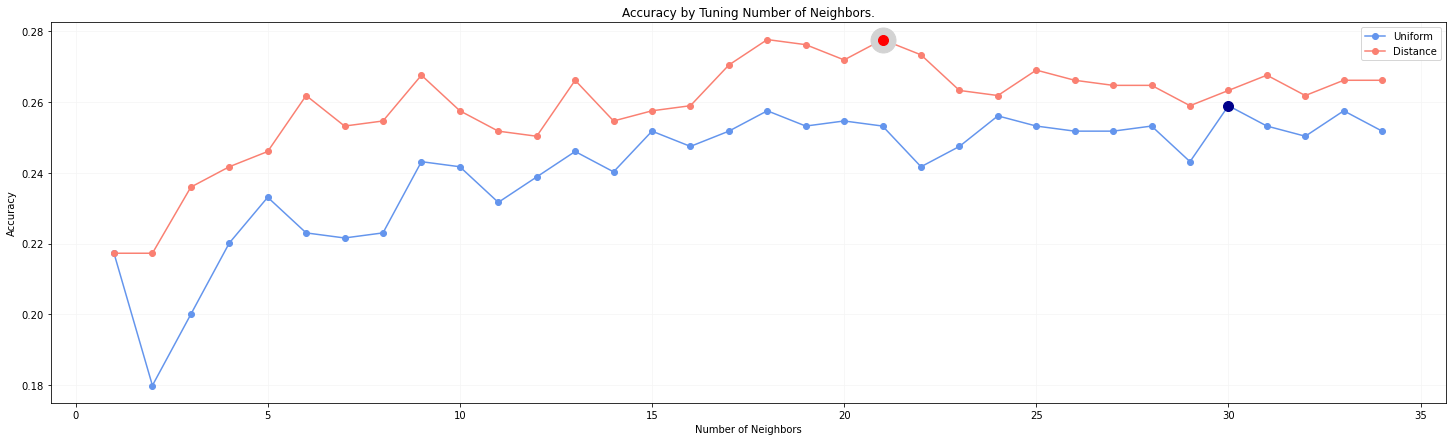

Accuracy: 0.277698 using: distance with 21 neighbors


In [19]:
neighbors, weights, acc = get_optimum_neighbors_and_accuracy(X_train_artist, y_train_artist, X_test_artist, y_test_artist, 35, True)
          
# results
results = results.append({"classifier" : "K-NN",
                          "group"      : "PALETTES-RBG",
                          "target"     : "ARTIST",
                          "score"      : round(acc, 6),
                          "params"     : {"neighbors" : neighbors, "weights" : weights}},
                          ignore_index = True)

print("Accuracy: {} using: {} with {} neighbors".format(round(acc, 6), weights, neighbors))

In [20]:
# create a training features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TRAIN, ARTIST, DATA, HLS))
X_train_artist = np.reshape(read_data(PALETTES, TRAIN, ARTIST, DATA, HLS), (r, l * f))

# create a test features dataFrame 
l, r, f = np.shape(read_data(PALETTES, TEST,  ARTIST, DATA, HLS))
X_test_artist  = np.reshape(read_data(PALETTES, TEST,  ARTIST, DATA, HLS), (r, l * f))

# create a training target catagories dataFrame
y_train_artist = read_data(PALETTES, TRAIN, ARTIST, CATAGORY, HLS)

# create a test target catagories  dataFrame
y_test_artist  = read_data(PALETTES, TEST,  ARTIST, CATAGORY, HLS)

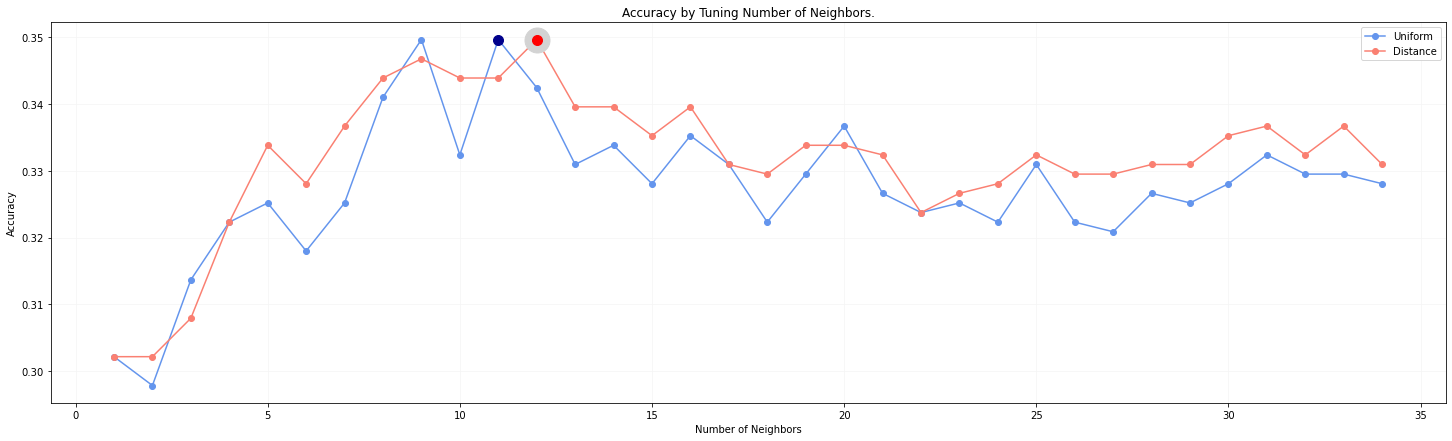

Accuracy: 0.34964 using: distance with 12 neighbors


In [21]:
neighbors, weights, acc = get_optimum_neighbors_and_accuracy(X_train_artist, y_train_artist, X_test_artist, y_test_artist, 35, True)
          
# results
results = results.append({"classifier" : "K-NN",
                          "group"      : "PALETTES-HLS",
                          "target"     : "ARTIST",
                          "score"      : round(acc, 6),
                          "params"     : {"neighbors" : neighbors, "weights" : weights}},
                          ignore_index = True)

print("Accuracy: {} using: {} with {} neighbors".format(round(acc, 6), weights, neighbors))

## Results
With all the tests completed we can now view the combined best results.

In [22]:
results

,classifier,group,params,score,target
0,K-NN,PALETTES-RGB,"{'neighbors': 26, 'weights': 'uniform'}",0.171223,GENRE
1,K-NN,PALETTES-HLS,"{'neighbors': 33, 'weights': 'uniform'}",0.220144,GENRE
2,K-NN,PALETTES-RGB,"{'neighbors': 33, 'weights': 'distance'}",0.137356,STYLE
3,K-NN,PALETTES-HLS,"{'neighbors': 13, 'weights': 'distance'}",0.200257,STYLE
4,K-NN,PALETTES-RBG,"{'neighbors': 21, 'weights': 'distance'}",0.277698,ARTIST
5,K-NN,PALETTES-HLS,"{'neighbors': 12, 'weights': 'distance'}",0.349640,ARTIST


__COMMENT:__ We see that the use of Palettes results in quite poor results.

## Write the Results to a File.
These are saved into a _.csv_ file to be used later in this section of the project.

In [23]:
results.to_csv("./data/hyperparameter_results/KNNforPalettesClassifier.csv", index = False)